In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, jaccard_score
from torch.utils.data import DataLoader, Dataset
from torchvision.models.segmentation import fcn_resnet50

In [2]:
def load_model(device: str = "cpu"):
    # Load the model architecture
    model = fcn_resnet50()

    # Modify the initial layer to accept 1 channel
    model.backbone.conv1 = nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )

    # Modify the final layer to output 2 channels
    model.classifier[-1] = nn.Conv2d(512, 2, kernel_size=1)

    # Send the model to the device
    model = model.to(device)

    return model


device = "cuda" if torch.cuda.is_available() else "cpu"

model = load_model(device)

model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, path: str):
        # Load the data
        with h5py.File(path) as f:
            self.images = np.array(f["images"])
            self.labels = np.array(f["labels"], dtype=np.uint8)

        # Ensure there are an equal number of images and masks
        assert len(self.images) == len(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        # Get the image-mask pair
        image = self.images[index]
        labels = self.labels[index]

        # Convert to tensors
        image = torch.unsqueeze(torch.Tensor(image), dim=0)
        labels = torch.Tensor(labels).long()

        return image, labels


train_data = SegmentationDataset("data/train.h5")
test_data = SegmentationDataset("data/test.h5")

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [4]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    loss_fn: nn.Module,
    epochs: int = 10,
):

    # Create the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):

        # Set the model to training mode
        model.train()

        for image, label in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Send the batch to the device
            image = image.to(device)
            label = label.to(device)

            # Get the predicted logits
            logits = model(image)["out"]

            # Convert to probabilities
            probabilities = torch.softmax(logits, dim=1)

            # Calculate the loss
            loss: torch.Tensor = loss_fn(probabilities, label)

            # Backpropagate
            loss.backward()
            optimizer.step()

        # Set the model to evaluation mode
        model.eval()

        # Calculate the test loss
        test_loss = 0
        test_IoU = 0
        test_accuracy = 0

        with torch.no_grad():
            for image, label in test_loader:
                # Send the image to the device
                image = image.to(device)

                # Get the predicted logits (1, 2, H, W)
                logits = model(image)["out"]

                # Convert to probabilities (1, 2, H, W)
                probabilities = torch.softmax(logits, dim=1).cpu()

                # Calculate loss
                test_loss += loss_fn(probabilities, label).item()

                # Get the predicted labels (H, W)
                predicted_label = (
                    torch.argmax(probabilities, axis=1).squeeze().cpu().numpy()
                )

                # Remove the unnecessary dimension (H, W)
                label = label.squeeze().numpy()

                # Calculate the IoU (jacaard score)
                test_IoU += jaccard_score(label, predicted_label, average="micro")

                # Calculate the pixel accuracy
                test_accuracy += accuracy_score(label, predicted_label)

        print(
            f"Epoch {epoch + 1:2}/{epochs} Metrics: CE Loss - {test_loss / len(test_loader):.3f} mIoU - {test_IoU / len(test_loader):.3f} MPA - {test_accuracy / len(test_loader):.3f}"
        )


train(model, train_loader, test_loader, nn.CrossEntropyLoss(), epochs=10)

Epoch  1/10 Metrics: Loss - 0.475 IoU -0.424 Accuracy - 0.188
Epoch  2/10 Metrics: Loss - 0.369 IoU -0.686 Accuracy - 0.246
Epoch  3/10 Metrics: Loss - 0.381 IoU -0.653 Accuracy - 0.225
Epoch  4/10 Metrics: Loss - 0.364 IoU -0.737 Accuracy - 0.244
Epoch  5/10 Metrics: Loss - 0.372 IoU -0.626 Accuracy - 0.249
Epoch  6/10 Metrics: Loss - 0.369 IoU -0.705 Accuracy - 0.259
Epoch  7/10 Metrics: Loss - 0.391 IoU -0.485 Accuracy - 0.255
Epoch  8/10 Metrics: Loss - 0.365 IoU -0.747 Accuracy - 0.246
Epoch  9/10 Metrics: Loss - 0.368 IoU -0.699 Accuracy - 0.253
Epoch 10/10 Metrics: Loss - 0.358 IoU -0.764 Accuracy - 0.253


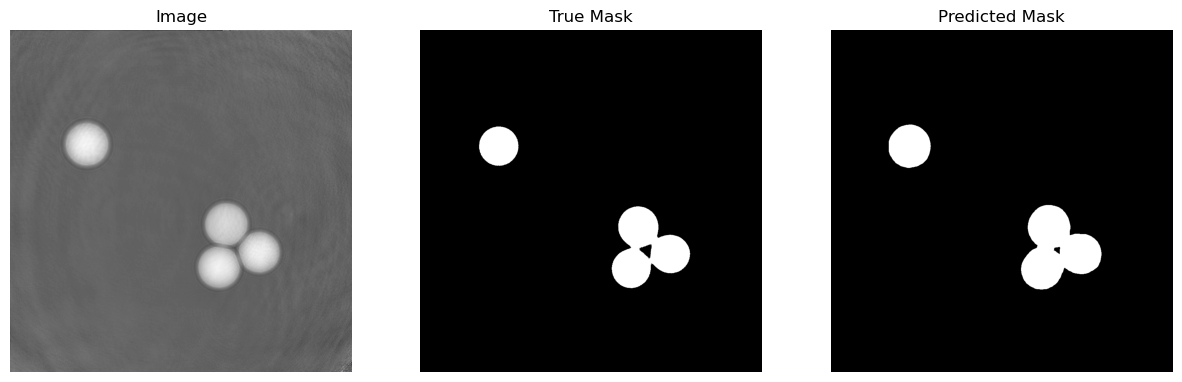

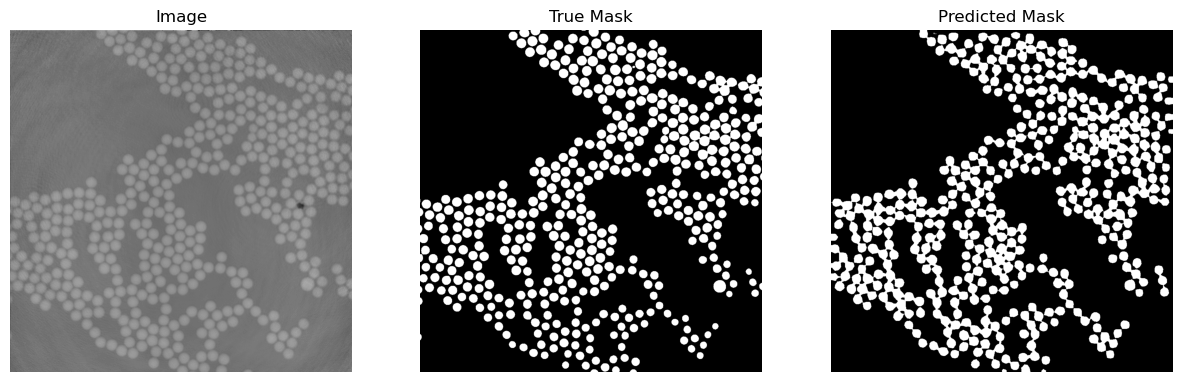

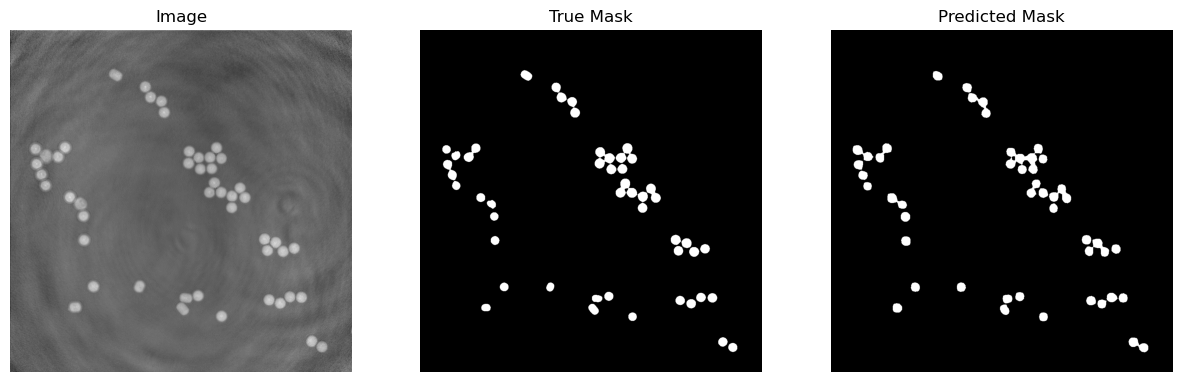

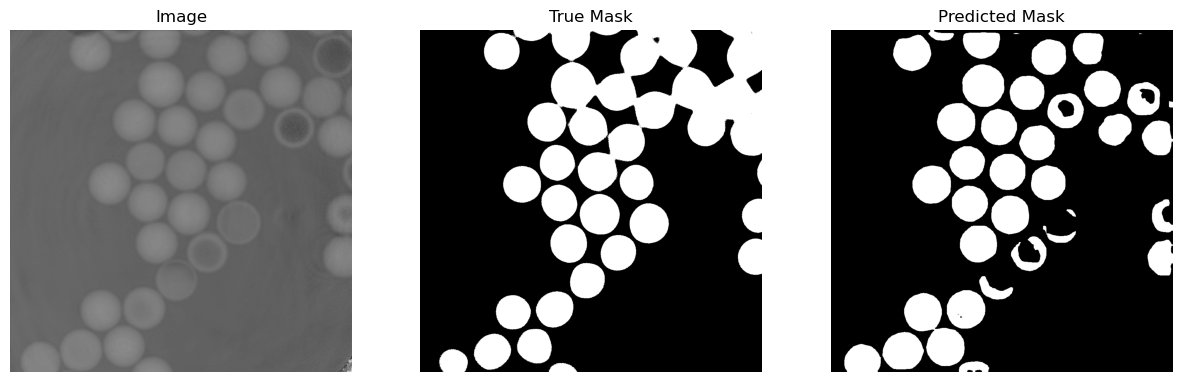

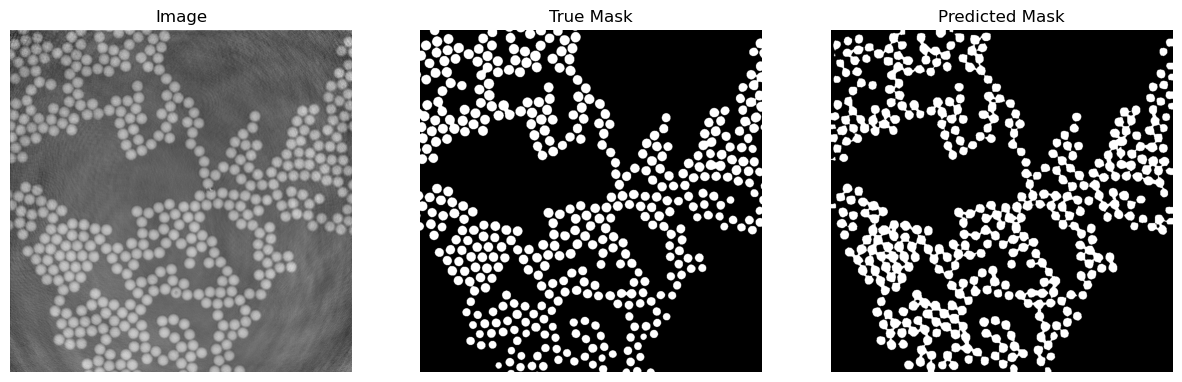

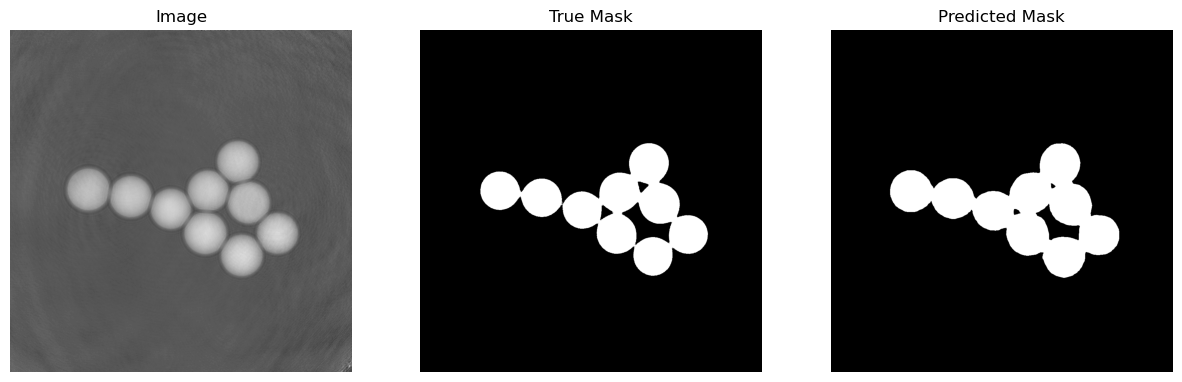

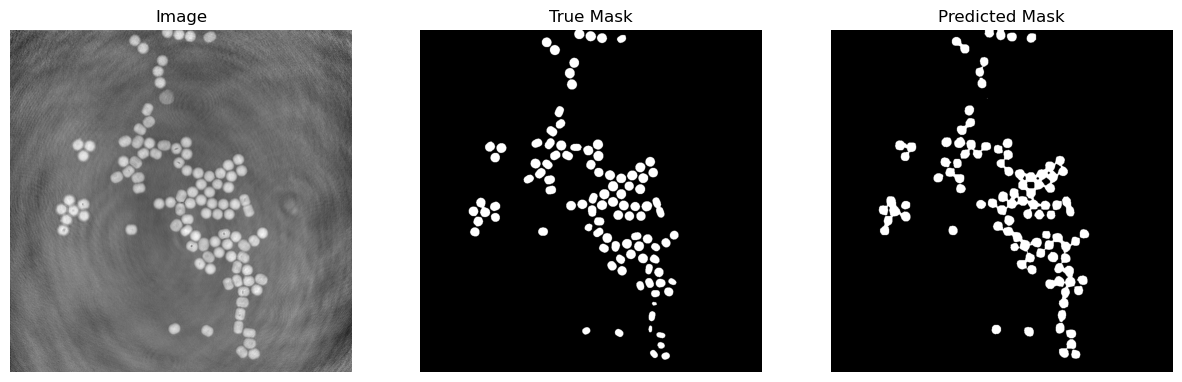

In [5]:
# Lets take a look at the predictions
model.eval()

with torch.no_grad():
    for image, label in test_loader:

        # Send the batch to the device
        image = image.to(device)
        label = label.to(device)

        # Get the predicted logits
        logits = model(image)["out"]

        # Convert to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted masks
        predicted_masks = torch.argmax(probabilities, dim=1)

        # Plot the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(image[0].squeeze().cpu().numpy(), cmap="gray")
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[1].imshow(label[0].squeeze().cpu().numpy(), cmap="gray")
        axes[1].set_title("True Mask")
        axes[1].axis("off")

        axes[2].imshow(predicted_masks[0].squeeze().cpu().numpy(), cmap="gray")
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.show()